<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/mdn_ae_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDN + AutoEncoder with Classifier
Created 6/25/2021

Creates a MDN to generate samples from the embedding learned by an autoencoder.

Open question: does this encourage clusters in the embedding space?

## Setup

In [1]:
#!conda install -y seaborn
#!conda install -y scikit-learn

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For MDN
import tensorflow_probability as tfp


In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
# !nvidia-smi

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
input_shape = (28, 28, 1)
num_classes = 10

# These settings worked well
# latent_dim = 8
# epochs = 50
# batch_size = 128
# learning_rate = 5e-4
# num_components = 5

latent_dim = 8
epochs = 75
batch_size = 128
learning_rate = 5e-4
num_components = 7

## Define the models

In [5]:
def encoder(input_shape):
    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name='enc_conv1')(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name='enc_conv2')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu", name='enc_dense1')(x)
    x = layers.Dense(latent_dim, name='latent_out')(x)
    model = tf.keras.Model(inputs, x, name='encoder')
    return model

In [6]:
def decoder():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    x = layers.Dense(7 * 7 * 64, activation="relu", name='dec_dense1')(inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name='dec_convtrans1')(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name='dec_convtrans2')(x)
    outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='dec_convtrans3')(x)
    model = tf.keras.Model(inputs, outputs, name="decoder")
    return model

In [7]:
def classifier():
    inputs = keras.Input(shape=(latent_dim,), name='input_layer')
    outp = layers.Dense(num_classes, activation="softmax", name='classifier_out')(inputs)
    model = tf.keras.Model(inputs, outp, name="classifier")
    return model

In [8]:
# Given the label, y, output the distribution over the latent space
def make_mdn_model(num_components=5):
    event_shape = [latent_dim]
    num_components = num_components
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    print('params_size:', params_size)

    inputs = keras.Input(shape=(num_classes,), name='input_layer')
    x = layers.Dense(128, activation="relu", name='hidden_layer')(inputs)
    x = layers.Dense(params_size, activation=None, name='penultimate_layer')(x)
    outp = tfp.layers.MixtureNormal(num_components=num_components, event_shape=event_shape)(x)
    model = tf.keras.Model(inputs, outp, name="mdn")
    return model

## Data

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


# One-hot encode the labels
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_train_one_hot shape:', y_train.shape)

n_train = x_train.shape[0]

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_train_one_hot shape: (60000,)


In [10]:
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)


## Create the model

In [11]:
# inputs = keras.Input(shape=input_shape, name='input_layer')
# inputs_labels = keras.Input(shape=(num_classes,), name='input_layer_labels')

# enc = encoder(input_shape)
# dec = decoder()
# clf = classifier()
# mdn = make_mdn_model(num_components)

# model = tf.keras.Model(
# 			inputs=[inputs, inputs_labels],
# 			outputs=[dec(enc(inputs)), clf(enc(inputs)), mdn(inputs_labels)],
# 			name="mdn_ae")

# # plot the autoencoder
# tf.keras.utils.plot_model(model, 'autoencoder_classifier.png', show_shapes=True)

## Train the model

In [12]:
# # loss function for distributions
# # (how likely is y under the distribution q?)
# negloglik = lambda y, q: -q.log_prob(y)

# losses = {
#     'decoder': 'mse',
#     'classifier': 'categorical_crossentropy',
#     'mdn': negloglik
# }

# wts = {
#     'decoder': 10.0, 
#     'classifier': 1.0,
#     'mdn': 10.0
# }

# opt = keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])
# hist = model.fit([x_train, y_train_one_hot], [x_train, y_train_one_hot, enc(x_train)], batch_size=batch_size, epochs=epochs, validation_split=0.1)


In [13]:
if False:

  # construct a plot that plots and saves the training history
  # plt.style.use("ggplot")
  plt.figure()
  plt.plot(hist.epoch, hist.history["loss"], label="train_loss")
  plt.plot(hist.epoch, hist.history["val_loss"], label="val_loss")
  plt.title("Overall Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('total_loss.png')
  plt.show()

  plt.figure()
  plt.plot(hist.epoch, hist.history["classifier_loss"], label="train_classifier_loss")
  # plt.plot(hist.epoch, hist.history["reconstruction_loss"], label="train_decoder_loss")
  # plt.plot(hist.epoch, hist.history["kl_loss"], label="train_kl_loss")
  plt.plot(hist.epoch, hist.history["val_classifier_loss"], label="val_classifier_loss")
  # plt.plot(hist.epoch, hist.history["val_reconstruction_loss"], label="val_decoder_loss")
  # plt.plot(hist.epoch, hist.history["val_kl_loss"], label="val_kl_loss")
  plt.title("Loss Breakout")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig('indiv_loss.png')
  plt.show()

  plt.figure()
  plt.plot(hist.epoch, hist.history["classifier_accuracy"], label="train_acc")
  plt.plot(hist.epoch, hist.history["val_classifier_accuracy"], label="val_acc")
  plt.title("Training Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.savefig('classifier_acc.png')
  plt.show()

## Problems
The problem with the built-in fit function is that apparently the encoding for the labels is not recalculated during training, so the MDN is learning to fit an outdated latent space and (it seems) the gradient due to MDN loss doesn't affect the encoding.

Below we'll try a custom training loop to address this issue.

params_size: 119


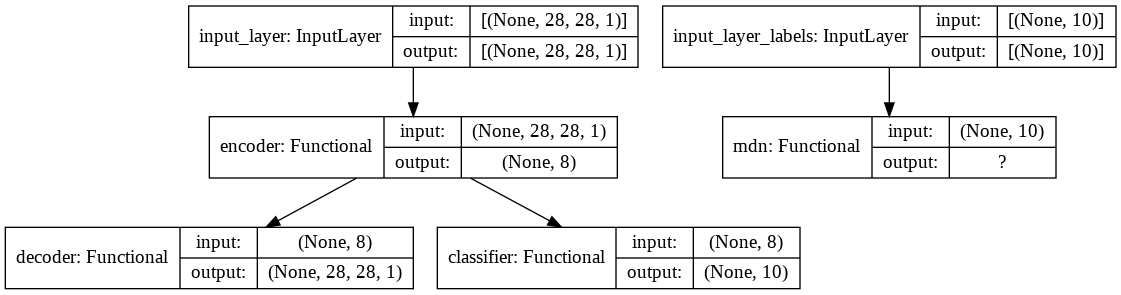

In [14]:
inputs = keras.Input(shape=input_shape, name='input_layer')
inputs_labels = keras.Input(shape=(num_classes,), name='input_layer_labels')

enc = encoder(input_shape)
dec = decoder()
clf = classifier()
mdn = make_mdn_model(num_components)

model = tf.keras.Model(
			inputs=[inputs, inputs_labels],
			outputs=[enc(inputs), dec(enc(inputs)), clf(enc(inputs)), mdn(inputs_labels)],
			name="mdn_ae")

# plot the autoencoder
tf.keras.utils.plot_model(model, 'autoencoder_classifier.png', show_shapes=True)


In [15]:
loss_func_dec = tf.keras.losses.mean_squared_error
loss_func_mdn = lambda y, q: -q.log_prob(y)
loss_func_clf = tf.keras.losses.categorical_crossentropy
lw = [10, 1, 2]

opt = keras.optimizers.Adam(learning_rate=learning_rate)

In [16]:
tf.reduce_mean(tf.keras.metrics.categorical_accuracy([[0, 0, 1], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    X, y = batch
    # print('DEBUG train_step:', X.shape, y.shape)

    with tf.GradientTape() as tape:
      # Forward pass
      z, Xhat, yhat, gmm = model([X, y])
      # print('  ending forward pass...')

      # Losses
      loss_dec = tf.reduce_sum(loss_func_dec(X, Xhat), axis=[1,2])
      # print('  loss_dec', loss_dec)
      loss_mdn = loss_func_mdn(z, gmm)
      # print('  loss_mdn', loss_mdn)
      # print('  classifier loss... y', y.shape, ', yhat', yhat.shape)
      loss_clf = loss_func_clf(y, yhat)
      # print('  loss_clf', loss_clf)
      loss = lw[0] * loss_dec + lw[1] * loss_mdn + lw[2] * loss_clf
      # print('  total loss', loss)

    grads = tape.gradient(loss, model.trainable_variables)
    # print('DEBUG:\n', grads)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    acc_dec = tf.keras.metrics.categorical_accuracy(y, yhat)

    return tf.reduce_mean(loss, axis=None), \
           tf.reduce_mean(loss_dec, axis=None), \
           tf.reduce_mean(loss_mdn, axis=None), \
           tf.reduce_mean(loss_clf, axis=None), \
           tf.reduce_mean(acc_dec, axis=None)

def train(dataset, epochs):
  # losses = np.zeros((epochs,))
  # Keep results for plotting
  train_loss_results = []
  train_accuracy_results = []

  for epoch in range(epochs):
    print('Epoch {:02d} of {:02d} ...'.format(epoch+1, epochs))
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_dec = tf.keras.metrics.Mean()
    epoch_loss_mdn = tf.keras.metrics.Mean()
    epoch_loss_clf = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Mean()
    # m = tf.keras.metrics.CategoricalAccuracy()
    # m.update_state([[0, 0, 1], [0, 1, 0]], [[0, 0, 1], [1, 1, 0]])
    # m.result().numpy()

    start = time.time()

    for image_batch in dataset:
      ret = train_step(image_batch)
      loss_value, loss_dec, loss_mdn, loss_clf, acc_dec = ret

      # Track progress
      epoch_loss_avg.update_state(loss_value)  # Add current batch loss
      epoch_loss_dec.update_state(loss_dec)  
      epoch_loss_mdn.update_state(loss_mdn)  
      epoch_loss_clf.update_state(loss_clf)  

      # X, y = image_batch
      # ysqueeze = np.argmax(y, axis=1)
      # yhat = model([X, y])[2]
      # yhat = np.argmax(yhat, axis=1)
      # acc = np.sum(ysqueeze == yhat)/len(y)
      # print('check...', ysqueeze.shape, yhat.shape)
      epoch_accuracy.update_state(acc_dec)
      # print('check')
      # print(epoch_accuracy.result())

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 1 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, DEC: {:.3f}, MDN: {:.3f}, CLF: {:.3f}, Acc: {:.3%}".format(epoch+1,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_loss_dec.result(),
                                                                  epoch_loss_mdn.result(),
                                                                  epoch_loss_clf.result(),
                                                                  epoch_accuracy.result()))
    
    # # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    # generate_and_save_images(mdn,
    #                          epoch + 1,
    #                          test_labels)

    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print('  over {} batches, avg loss is {:.4f}'.format(batches, avg_loss))

  # # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(mdn,
  #                          epochs,
  #                          test_labels)
  
  return train_loss_results, train_accuracy_results


Epoch 01 of 75 ...
Epoch 001: Loss: 497.211, DEC: 48.407, MDN: 8.514, CLF: 2.312, Acc: 15.302%
Time for epoch 1 is 11.489419937133789 sec
Epoch 02 of 75 ...
Epoch 002: Loss: 234.838, DEC: 23.142, MDN: -0.644, CLF: 2.033, Acc: 36.607%
Time for epoch 2 is 7.182863235473633 sec
Epoch 03 of 75 ...
Epoch 003: Loss: 193.263, DEC: 19.163, MDN: -2.227, CLF: 1.928, Acc: 48.503%
Time for epoch 3 is 7.164979457855225 sec
Epoch 04 of 75 ...
Epoch 004: Loss: 177.231, DEC: 17.679, MDN: -3.239, CLF: 1.838, Acc: 56.256%
Time for epoch 4 is 7.114757776260376 sec
Epoch 05 of 75 ...
Epoch 005: Loss: 167.366, DEC: 16.793, MDN: -4.093, CLF: 1.762, Acc: 61.758%
Time for epoch 5 is 7.157736539840698 sec
Epoch 06 of 75 ...
Epoch 006: Loss: 160.276, DEC: 16.172, MDN: -4.835, CLF: 1.696, Acc: 66.176%
Time for epoch 6 is 7.244391918182373 sec
Epoch 07 of 75 ...
Epoch 007: Loss: 154.598, DEC: 15.678, MDN: -5.453, CLF: 1.635, Acc: 69.883%
Time for epoch 7 is 7.151356220245361 sec
Epoch 08 of 75 ...
Epoch 008: Loss

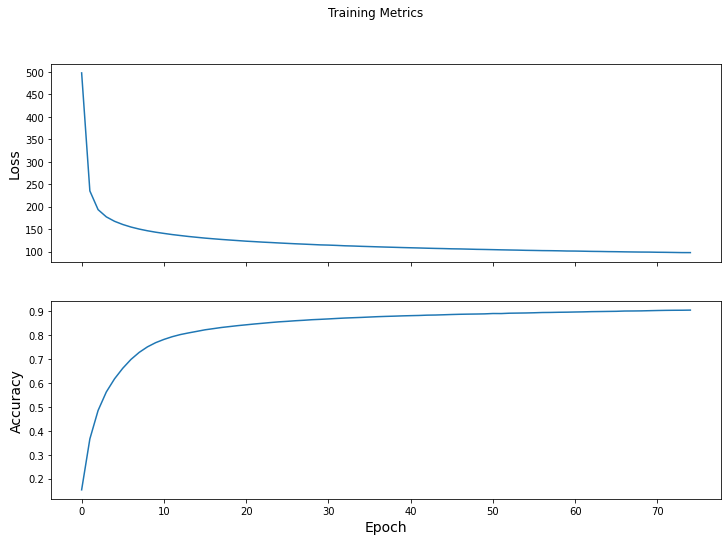

In [18]:
train_loss_results, train_accuracy_results = train(train_dataset, epochs)

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


Test Accuracy: 0.9052
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.92      0.99      0.96      1135
           2       0.94      0.92      0.93      1032
           3       0.89      0.94      0.91      1010
           4       0.92      0.91      0.91       982
           5       0.92      0.81      0.86       892
           6       0.92      0.94      0.93       958
           7       0.86      0.90      0.88      1028
           8       0.89      0.87      0.88       974
           9       0.87      0.79      0.83      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.90     10000



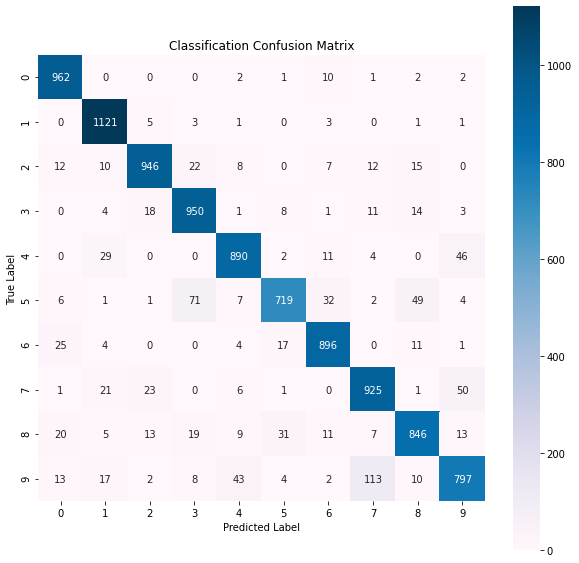

In [19]:
# Check accuracy

# Encode the input image
z = enc(x_test)

# Classify the latent code
y_pred = clf(z)

m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(y_test_one_hot, y_pred)
print('Test Accuracy:', m.result().numpy())

y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 10))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="PuBu")

plt.xlabel('Predicted Label');
plt.ylabel('True Label')
plt.title('Classification Confusion Matrix')
plt.show()


## Visualizations

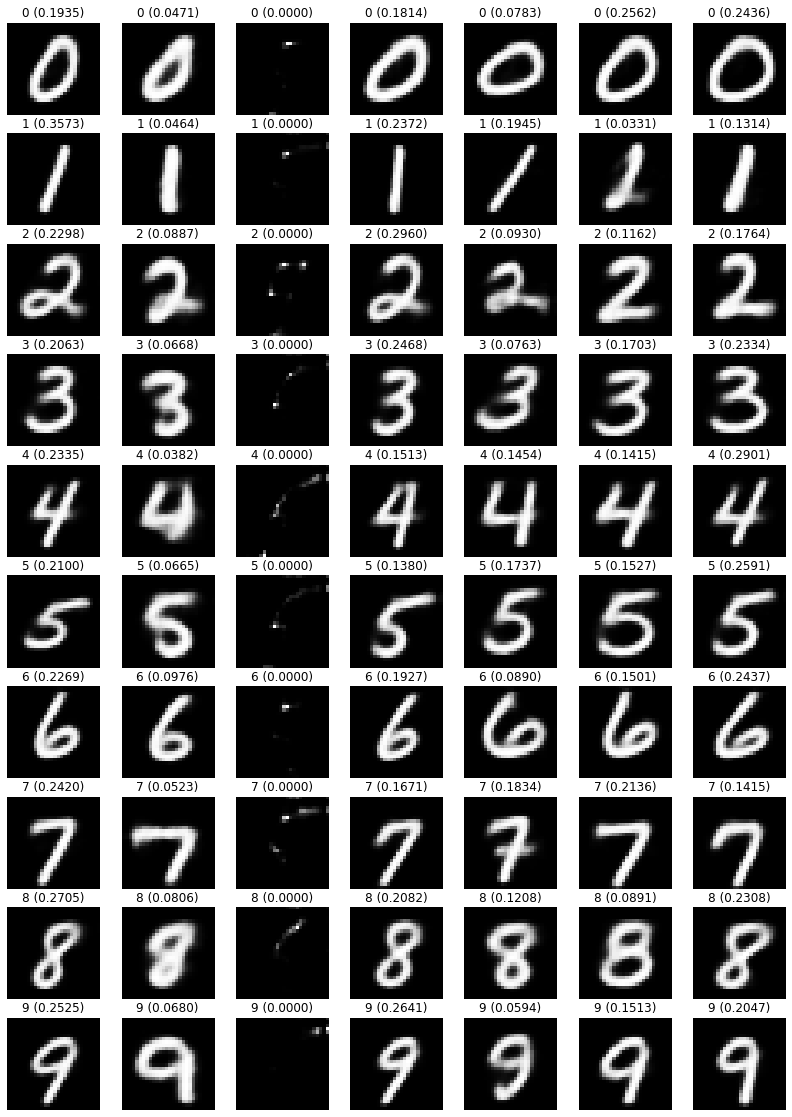

In [20]:
epoch = 10

test_input = np.eye(10)

# def generate_and_save_images(test_input):
# Notice `training` is set to False.
# This is so all layers run in inference mode (batchnorm).
gmm = mdn(test_input, training=False)

num_rows = test_input.shape[0]
idx = 0
plt.figure(figsize=(num_components*2, num_rows*2))
for i in range(num_rows):
  for k in range(num_components):
    idx += 1
    plt.subplot(num_rows, num_components, idx)
    w = gmm.mixture_distribution.probs_parameter().numpy()[i, k]
    plt.title('{} ({:.4f})'.format(i, w))
    sample = gmm.components_distribution.mean()[i, k]
    sample = np.reshape(sample, (1, -1))
    img = dec(sample)
    img = np.reshape(img, (28, 28))
    plt.imshow(img * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()


## Display how the latent space clusters different digit classes

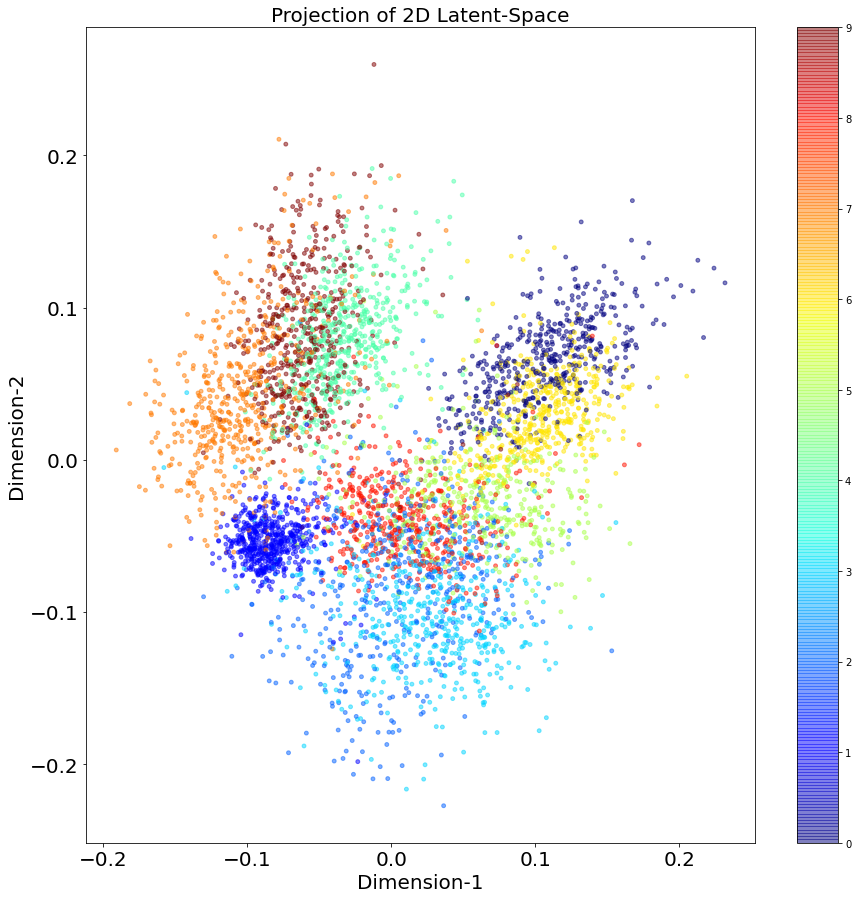

In [21]:
imgs_visualize = 5000
figsize = 15
show_gmm_modes = False

def plot_label_clusters(data, labels, use_pca=False):
    # display a 2D plot of the digit classes in the latent space
    z = enc(data)

    if use_pca:
      pca = PCA(n_components=2)
      pca.fit(z)
      z = pca.transform(z)


    plt.figure(figsize=(figsize, figsize))
    plt.scatter(z[:, 0], z[:, 1], 15, c=labels, cmap='jet', alpha=0.5)

    if show_gmm_modes:
      test_input = tf.one_hot(np.arange(num_classes), num_classes)
      gmm = mdn(test_input, training=False)
      for i in range(num_classes):
        for k in range(num_components):
          z = gmm.components_distribution.mean()[i, k]
          w = 40*gmm.mixture_distribution.probs_parameter().numpy()[i, k]
          s = gmm.components_distribution.stddev()[i, k].numpy()
          s = 10*np.linalg.norm(s)
          # print('Digit {:d} ({:d}): ({:.2f}, {:.2f}) {:.4f} {:.4f}'.format(i, k, z[0], z[1], w, s))
          print(i, '-', k, ':  (', z[0].numpy(), z[1].numpy(), ')  ', w, s)
          plt.plot(z[0], z[1], 'ok', MarkerSize=w, MarkerFaceColor='white')

    plt.colorbar()
    plt.xlabel("Dimension-1", size=20)
    plt.ylabel("Dimension-2", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Projection of 2D Latent-Space", size=20)
    plt.show()

plot_label_clusters(x_train[:imgs_visualize], y_train[:imgs_visualize], True)


## Display a grid of sampled digits

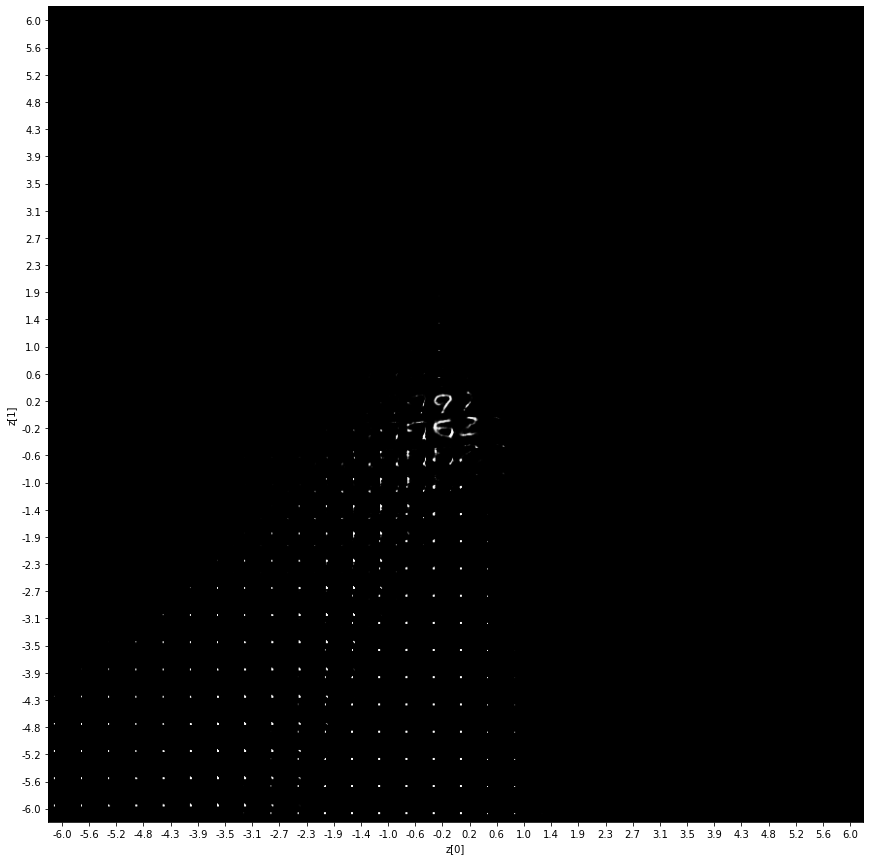

In [22]:
def plot_latent_space(n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 6.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1, latent_dim))
            z_sample[0, 0] = xi
            z_sample[0, 1] = yi
            # z_sample = np.array([[xi, yi]])
            x_decoded = dec(z_sample)
            digit = np.reshape(x_decoded[0], (digit_size, digit_size))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space()

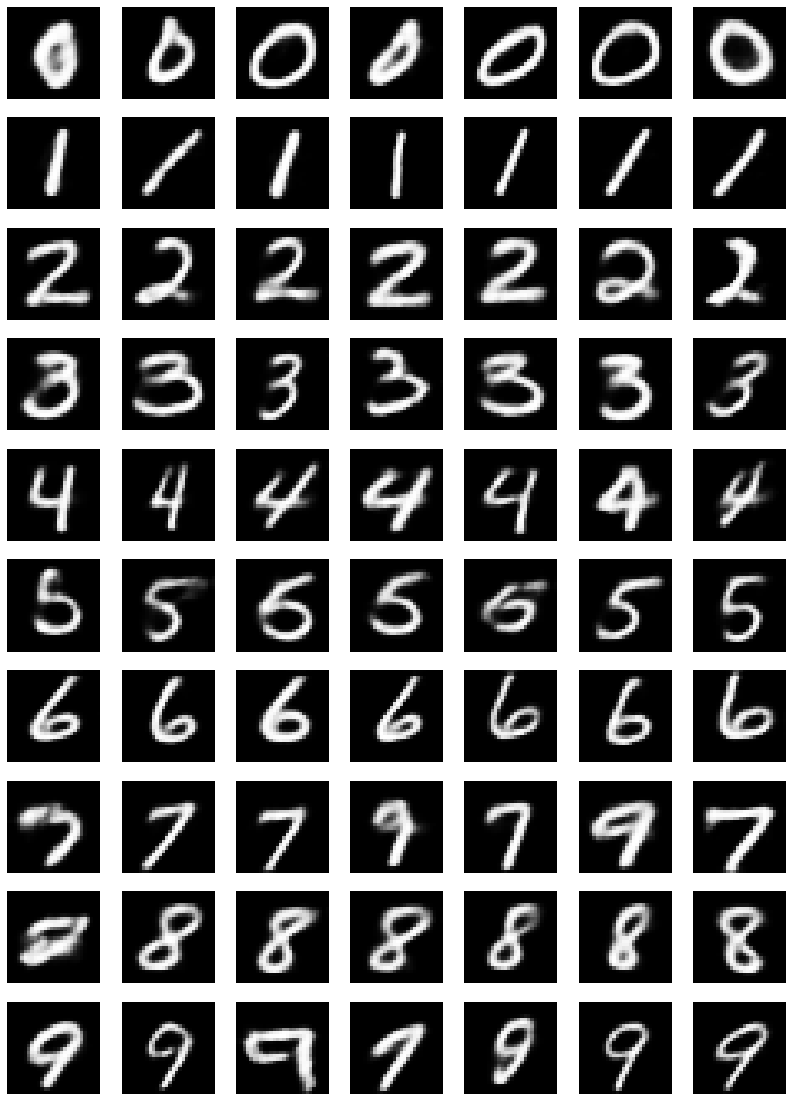

In [23]:
# Random sampling from the MDN
num_rows = 10
idx = 0
plt.figure(figsize=(num_components*2, num_rows*2))
for i in range(num_rows):
  for k in range(num_components):
    idx += 1
    plt.subplot(num_rows, num_components, idx)
    # w = gmm.mixture_distribution.probs_parameter().numpy()[i, k]
    # plt.title('{} ({:.4f})'.format(i, w))
    # sample = gmm.components_distribution.mean()[i, k]
    test_input = tf.one_hot([i], num_classes)
    gmm = mdn(test_input, training=False)
    sample = gmm.sample()
    sample = np.reshape(sample, (1, -1))
    img = dec(sample)
    img = np.reshape(img, (28, 28))
    plt.imshow(img * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.savefig('samples.png')
plt.show()